In [1]:
import torch
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
USE_GPU = True
num_class = 100
dtype = torch.float32 # we will be using float throughout this tutorial
device = torch.device("cpu")
try:
    if USE_GPU and torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device('cpu')
except:
    if USE_GPU and torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: mps


In [3]:
BASE = "lung_colon_image_set/"

In [4]:
class LungColonDS(torchvision.datasets.DatasetFolder):
    def find_classes(self, directory: str):
        classes = ["colon_image_sets/colon_aca","colon_image_sets/colon_n","lung_image_sets/lung_aca","lung_image_sets/lung_n","lung_image_sets/lung_scc"]
        return classes, {val:ind for ind, val in enumerate(classes)}

In [5]:
lung_colon_dataset = LungColonDS(BASE,torchvision.io.read_image, extensions = [".jpeg"])

In [6]:
lung_colon_dataset.classes

['colon_image_sets/colon_aca',
 'colon_image_sets/colon_n',
 'lung_image_sets/lung_aca',
 'lung_image_sets/lung_n',
 'lung_image_sets/lung_scc']

In [7]:
train_count = int(0.7*len(lung_colon_dataset))
valid_count = len(lung_colon_dataset) - train_count
train_dataset, valid_dataset = torch.utils.data.random_split(lung_colon_dataset, [train_count, valid_count])

In [8]:
train_subset = np.array([lung_colon_dataset[i] for i in train_dataset.indices if i<100])

/var/folders/0x/m1s6swtx3c5dl010fbkgb5280000gn/T/ipykernel_2049/14402734.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  train_subset = np.array([lung_colon_dataset[i] for i in train_dataset.indices if i<100])
/var/folders/0x/m1s6swtx3c5dl010fbkgb5280000gn/T/ipykernel_2049/14402734.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_subset = np.array([lung

# Plotting a Image from the Data Set

/var/folders/0x/m1s6swtx3c5dl010fbkgb5280000gn/T/ipykernel_2049/3583082000.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682147326800/work/aten/src/ATen/native/TensorShape.cpp:3582.)
  plt.imshow(train_subset[0][0].T)


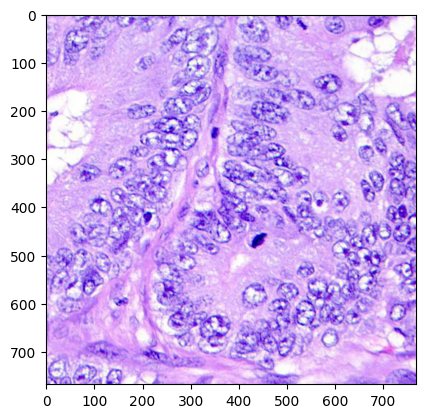

In [9]:
plt.imshow(train_subset[0][0].T)

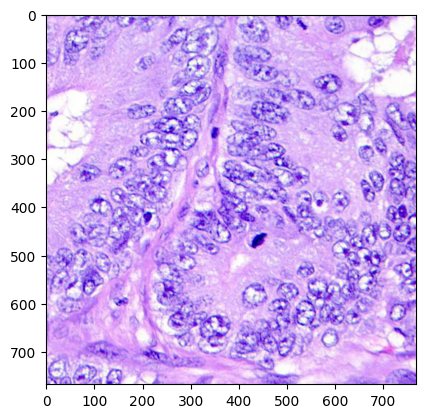

In [22]:
def plotImage(image):
    return plt.imshow(image.T)
plotImage(train_subset[0][0])

# Confirming We Have Representative Datasets
Confirming we have multiple examples of each class in DataSets

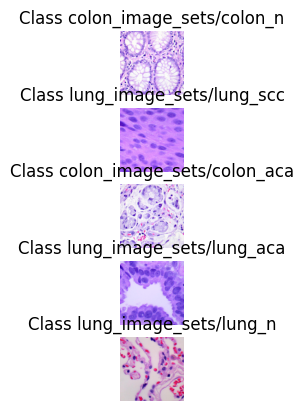

In [10]:
found = dict()
fig = plt.figure()
axes = []
for i in train_dataset:
    if i[1] not in found:
        found[i[1]] = i[0]
        axes.append(fig.add_subplot(5, 1, len(axes)+1))
        axes[-1].imshow(i[0].T)
        axes[-1].set_title(f"Class {lung_colon_dataset.classes[i[1]]}")
        axes[-1].set_axis_off()
    if len(found) == 5:
        break
assert len(found) == 5
plt.show()

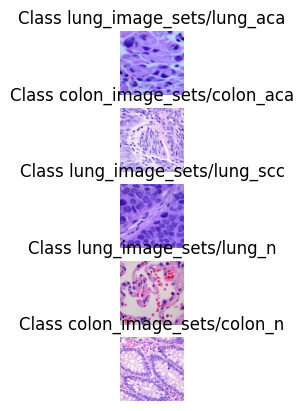

In [11]:
found = dict()
fig = plt.figure()
axes = []
for i in valid_dataset:
    if i[1] not in found:
        found[i[1]] = i[0]
        axes.append(fig.add_subplot(5, 1, len(axes)+1))
        axes[-1].imshow(i[0].T)
        axes[-1].set_title(f"Class {lung_colon_dataset.classes[i[1]]}")
        axes[-1].set_axis_off()
    if len(found) == 5:
        break
assert len(found) == 5
plt.show()

# Making Dataloader
Dataloaders is how we will present the data to the trainer, so we need to create this object. In the future, these can be adjusted to handle any kind of new distribution we want to make

In [14]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

In [16]:
out = next(iter(train_dataloader))

In [24]:
out

[tensor([[[[173, 175, 175,  ..., 147, 146, 146],
           [173, 174, 175,  ..., 143, 142, 142],
           [172, 173, 173,  ..., 141, 140, 140],
           ...,
           [164, 164, 164,  ..., 171, 169, 168],
           [166, 165, 165,  ..., 172, 171, 170],
           [165, 164, 165,  ..., 172, 172, 172]],
 
          [[157, 159, 159,  ..., 123, 123, 121],
           [157, 158, 159,  ..., 119, 118, 117],
           [156, 157, 157,  ..., 117, 116, 115],
           ...,
           [152, 152, 152,  ..., 164, 162, 161],
           [152, 151, 150,  ..., 165, 164, 163],
           [151, 150, 150,  ..., 165, 165, 165]],
 
          [[219, 221, 221,  ..., 219, 214, 213],
           [219, 220, 221,  ..., 215, 212, 209],
           [218, 219, 219,  ..., 213, 210, 207],
           ...,
           [214, 216, 216,  ..., 216, 214, 213],
           [214, 213, 215,  ..., 216, 216, 215],
           [212, 212, 215,  ..., 216, 217, 217]]],
 
 
         [[[175, 175, 175,  ..., 168, 157, 151],
         

# Randomly Rotating Every Image by A Certain Amount

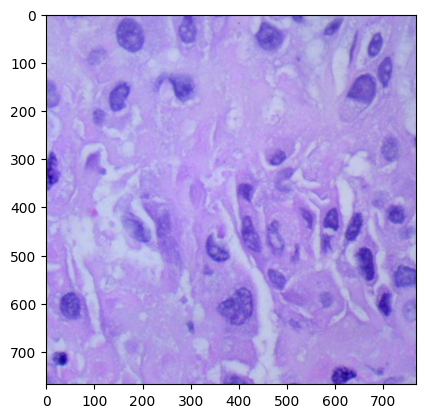

In [32]:
img = out[0][0]
plotImage(img)

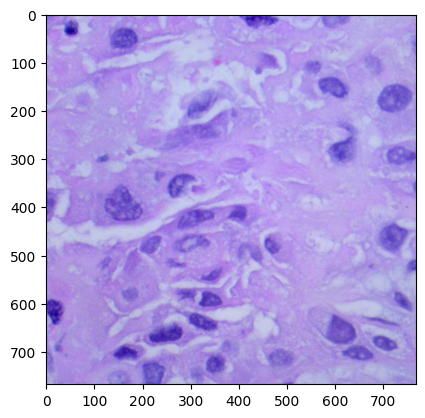

In [35]:
plotImage(torchvision.transforms.functional.rotate(img, 90))

Works for one image. Documentation only mentions for one but Ill try with a batch and see what happens

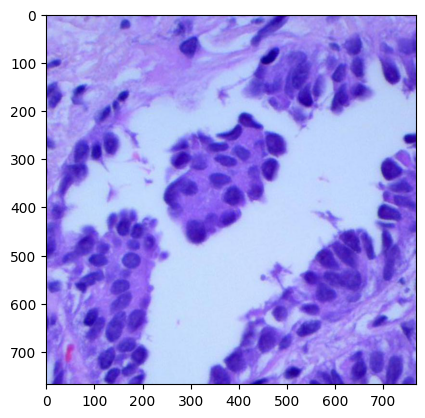

In [36]:
plotImage(out[0][5])

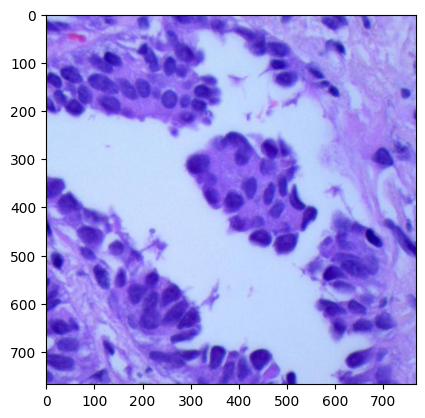

In [38]:
plotImage(torchvision.transforms.functional.rotate(out[0], 90)[5])

Appears to work for multiple!

In [52]:
import rotationDataloaders

In [53]:
next(rotationDataloaders.RotatedDatasetOriginalClasses(iter(train_dataloader)))

(tensor([[[[194, 195, 196,  ..., 199, 199, 199],
           [194, 195, 196,  ..., 198, 198, 198],
           [194, 195, 196,  ..., 198, 198, 198],
           ...,
           [195, 195, 194,  ..., 169, 168, 168],
           [195, 195, 194,  ..., 166, 166, 166],
           [195, 195, 194,  ..., 165, 165, 166]],
 
          [[200, 201, 202,  ..., 208, 208, 208],
           [200, 201, 202,  ..., 207, 207, 207],
           [200, 201, 202,  ..., 207, 207, 207],
           ...,
           [200, 200, 199,  ...,  88,  87,  87],
           [200, 200, 199,  ...,  85,  85,  85],
           [200, 200, 199,  ...,  83,  83,  84]],
 
          [[200, 201, 202,  ..., 207, 207, 207],
           [200, 201, 202,  ..., 206, 206, 206],
           [200, 201, 202,  ..., 206, 206, 206],
           ...,
           [196, 196, 195,  ..., 167, 166, 164],
           [196, 196, 195,  ..., 164, 164, 164],
           [196, 196, 195,  ..., 165, 165, 166]]],
 
 
         [[[161, 159, 157,  ..., 199, 178, 160],
         